In [52]:
# Importing the Libarary
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
# Load your uploaded dataset
df = pd.read_csv("/content/Germany_co2_data.csv")

In [29]:
df.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Germany,1965,DEU,75966964,1.110000e+12,19.880,0.262,960.102,-8.815,-0.910,...,NaN,4.270,0.005,0.019,0.025,0.001,1168.769,1117.619,NaN,NaN
1,Germany,1966,DEU,76611028,1.140000e+12,20.356,0.266,951.422,-8.680,-0.904,...,NaN,4.287,0.005,0.019,0.025,0.001,1161.445,1109.750,NaN,NaN
2,Germany,1967,DEU,76970793,1.140000e+12,19.211,0.250,936.229,-15.193,-1.597,...,NaN,4.292,0.006,0.019,0.026,0.001,1149.323,1095.939,NaN,NaN
3,Germany,1968,DEU,77321278,1.200000e+12,20.261,0.262,984.791,48.561,5.187,...,NaN,4.297,0.006,0.020,0.026,0.001,1204.140,1149.552,NaN,NaN
4,Germany,1969,DEU,77944023,1.280000e+12,21.003,0.269,1052.001,67.210,6.825,...,NaN,4.299,0.006,0.020,0.027,0.001,1278.332,1223.810,NaN,NaN


In [30]:
df.tail()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
54,Germany,2019,DEU,83559185,3.890000e+12,13.287,0.159,709.827,-50.220,-6.607,...,2.790,2.998,0.004,0.041,0.047,0.002,793.775,753.911,NaN,NaN
55,Germany,2020,DEU,83628711,3.740000e+12,13.357,0.160,648.357,-61.470,-8.660,...,2.725,2.969,0.004,0.041,0.047,0.002,729.728,691.065,NaN,NaN
56,Germany,2021,DEU,83697082,3.840000e+12,13.640,0.163,678.777,30.420,4.692,...,2.792,2.940,0.004,0.041,0.048,0.002,759.036,722.425,NaN,NaN
57,Germany,2022,DEU,84086228,3.910000e+12,12.538,0.149,671.472,-7.306,-1.076,...,2.734,2.911,0.004,0.042,0.048,0.002,747.968,713.675,NaN,NaN
58,Germany,2023,DEU,84548234,NaN,10.604,0.125,596.151,-75.320,-11.217,...,2.712,2.881,0.004,0.042,0.048,0.002,670.626,637.367,NaN,NaN


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    59 non-null     object 
 1   year                                       59 non-null     int64  
 2   iso_code                                   59 non-null     object 
 3   population                                 59 non-null     int64  
 4   gdp                                        58 non-null     float64
 5   cement_co2                                 59 non-null     float64
 6   cement_co2_per_capita                      59 non-null     float64
 7   co2                                        59 non-null     float64
 8   co2_growth_abs                             59 non-null     float64
 9   co2_growth_prct                            59 non-null     float64
 10  co2_including_luc           

In [32]:
# Removal of unused data Keeping only year and CO2
germany = df[["year", "co2"]].dropna().sort_values("year")
germany.head()

,year,co2
0,1965,960.102
1,1966,951.422
2,1967,936.229
3,1968,984.791
4,1969,1052.001


In [33]:
# Removal of unused data Keeping only year and CO2
germany.tail()

,year,co2
54,2019,709.827
55,2020,648.357
56,2021,678.777
57,2022,671.472
58,2023,596.151


In [34]:
# Scale CO₂ for LSTM
scaler = MinMaxScaler(feature_range=(0,1))
scaled_co2 = scaler.fit_transform(germany["co2"].values.reshape(-1,1))

In [35]:
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)
time_steps = 10
X, y = create_sequences(scaled_co2, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM format

In [36]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=200, batch_size=8, verbose=1)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3359
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3099
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2424 
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1399 
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0638 
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086
Epoch 13/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 
Epoch 14/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 
Epoch 15/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 
Epoch 16/200
7/7 ━━━━━━━━━━━━━━━

In [37]:
# Start with last 10 years
last_sequence = scaled_co2[-time_steps:]
sequence = last_sequence
future_predictions = []

for _ in range(2):  # predict for 2024 and 2025
    pred = model.predict(sequence.reshape(1, time_steps, 1))
    future_predictions.append(pred[0,0])
    sequence = np.append(sequence[1:], pred).reshape(time_steps, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [38]:
# Convert back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

print(f"Predicted CO₂ in 2024: {future_predictions[0,0]:.2f} million tonnes")
print(f"Predicted CO₂ in 2025: {future_predictions[1,0]:.2f} million tonnes")

Predicted CO₂ in 2024: 550.02 million tonnes
Predicted CO₂ in 2025: 501.78 million tonnes


Predictions:
59    609.251398
60    603.456025
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

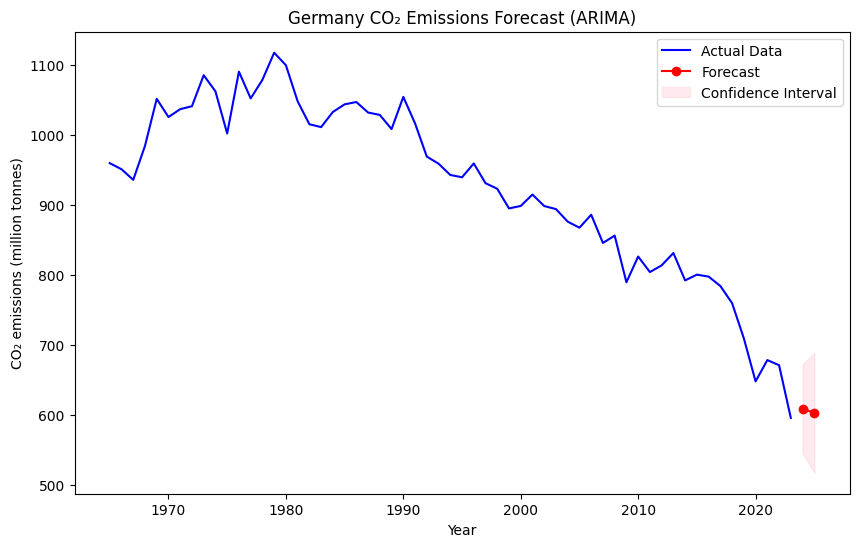

In [39]:
# Keep only year and co2
germany = df[["year", "co2"]].dropna().sort_values("year")
germany.set_index("year", inplace=True)

# Fit ARIMA model (order can be tuned)
model = ARIMA(germany["co2"], order=(2,1,2))
model_fit = model.fit()

# Forecast for 2024 & 2025
forecast = model_fit.get_forecast(steps=2)
pred_mean = forecast.predicted_mean
pred_conf = forecast.conf_int()

print("Predictions:")
print(pred_mean)

# Visualization
plt.figure(figsize=(10,6))
plt.plot(germany.index, germany["co2"], label="Actual Data", color="blue")

# Forecast line
future_years = [2024, 2025]
plt.plot(future_years, pred_mean, label="Forecast", color="red", marker="o")

# Confidence interval
plt.fill_between(future_years,
                 pred_conf["lower co2"],
                 pred_conf["upper co2"],
                 color="pink", alpha=0.3, label="Confidence Interval")

plt.title("Germany CO₂ Emissions Forecast (ARIMA)")
plt.xlabel("Year")
plt.ylabel("CO₂ emissions (million tonnes)")
plt.legend()
plt.show()

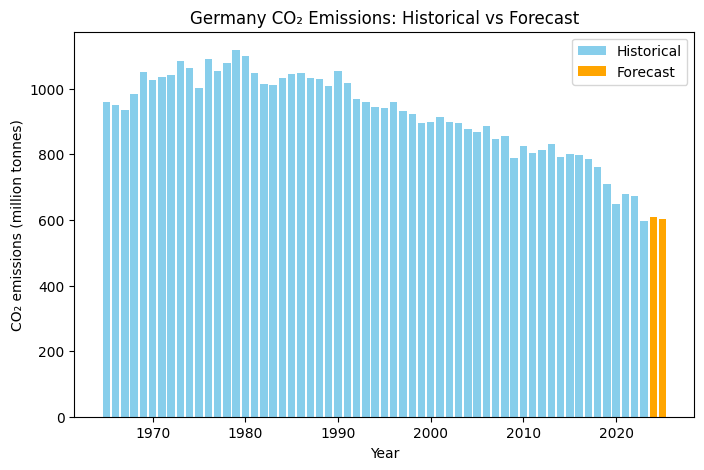

In [40]:
plt.figure(figsize=(8,5))
plt.bar(germany.index, germany["co2"], label="Historical", color="skyblue")
plt.bar([2024, 2025], pred_mean, label="Forecast", color="orange")
plt.title("Germany CO₂ Emissions: Historical vs Forecast")
plt.xlabel("Year")
plt.ylabel("CO₂ emissions (million tonnes)")
plt.legend()
plt.show()

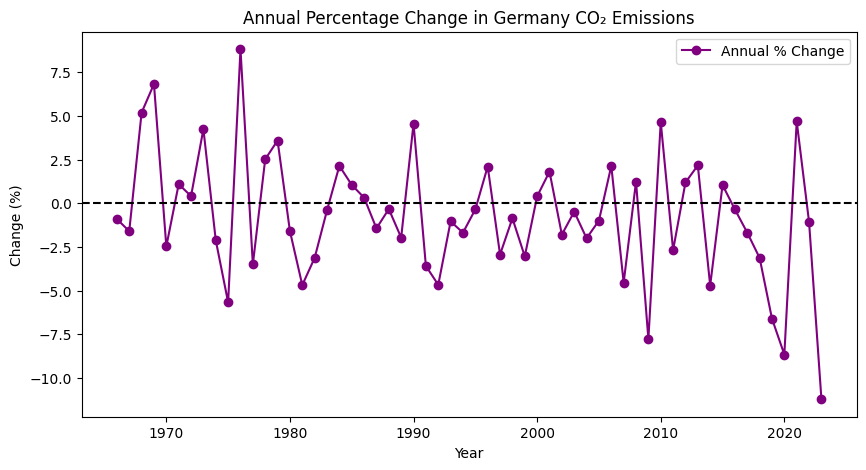

In [41]:
# Compute yearly change
germany["change"] = germany["co2"].pct_change() * 100

plt.figure(figsize=(10,5))
plt.plot(germany.index, germany["change"], marker="o", color="purple", label="Annual % Change")
plt.axhline(0, color="black", linestyle="--")
plt.title("Annual Percentage Change in Germany CO₂ Emissions")
plt.xlabel("Year")
plt.ylabel("Change (%)")
plt.legend()
plt.show()

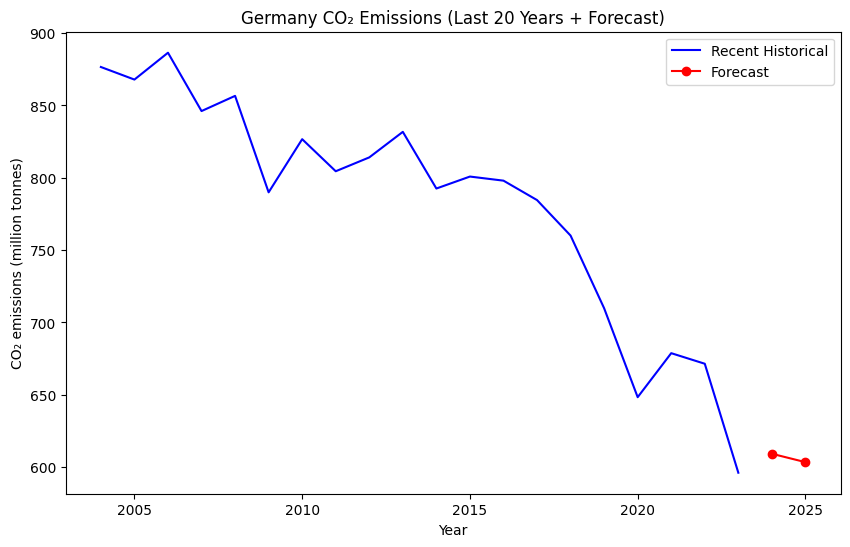

In [42]:
plt.figure(figsize=(10,6))
plt.plot(germany.index[-20:], germany["co2"][-20:], label="Recent Historical", color="blue")
plt.plot([2024, 2025], pred_mean, marker="o", color="red", label="Forecast")
plt.title("Germany CO₂ Emissions (Last 20 Years + Forecast)")
plt.xlabel("Year")
plt.ylabel("CO₂ emissions (million tonnes)")
plt.legend()
plt.show()

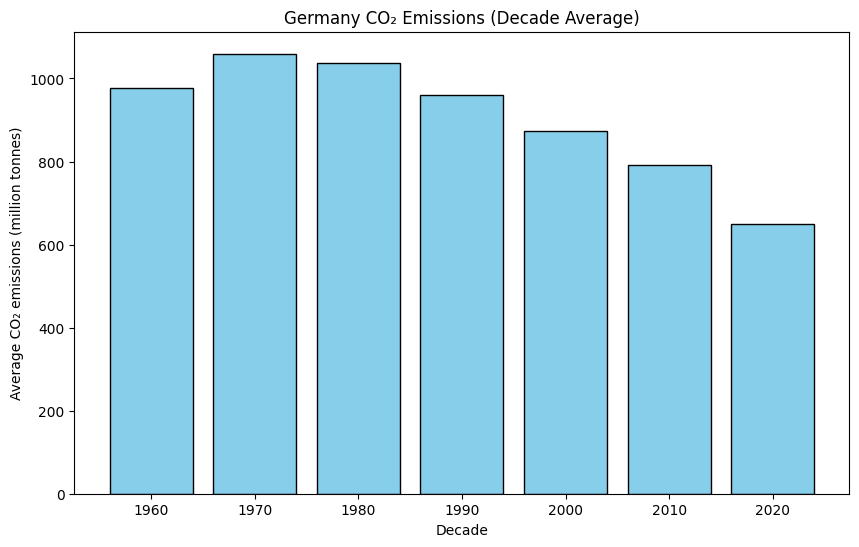

In [43]:
germany = df[["year", "co2"]].dropna().sort_values("year")

# Create decade column (e.g., 1990s, 2000s, etc.)
germany["decade"] = (germany["year"] // 10) * 10

# Calculate average CO₂ per decade
decade_avg = germany.groupby("decade")["co2"].mean().reset_index()

# --- Visualization 1: Bar Chart (average emissions per decade) ---
plt.figure(figsize=(10,6))
plt.bar(decade_avg["decade"], decade_avg["co2"], width=8, color="skyblue", edgecolor="black")
plt.title("Germany CO₂ Emissions (Decade Average)")
plt.xlabel("Decade")
plt.ylabel("Average CO₂ emissions (million tonnes)")
plt.xticks(decade_avg["decade"])
plt.show()


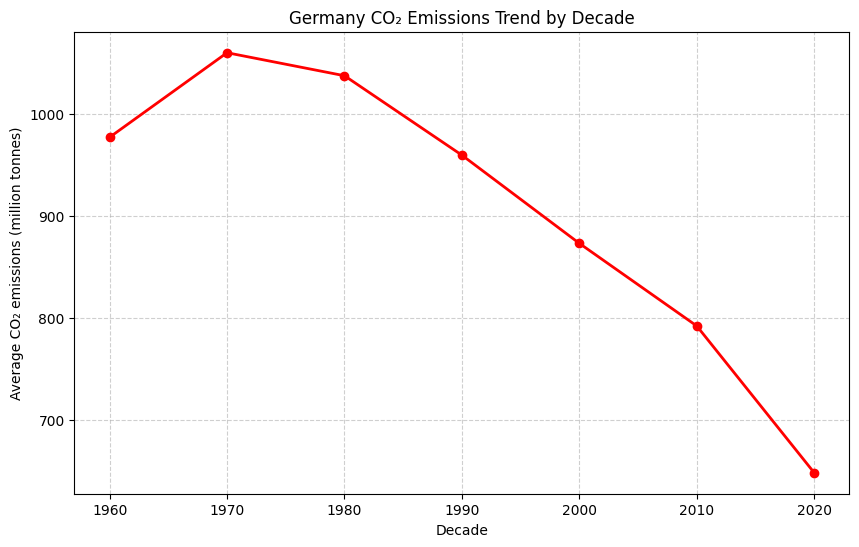

In [44]:


# --- Visualization 2: Line Chart (trend across decades) ---
plt.figure(figsize=(10,6))
plt.plot(decade_avg["decade"], decade_avg["co2"], marker="o", color="red", linewidth=2)
plt.title("Germany CO₂ Emissions Trend by Decade")
plt.xlabel("Decade")
plt.ylabel("Average CO₂ emissions (million tonnes)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

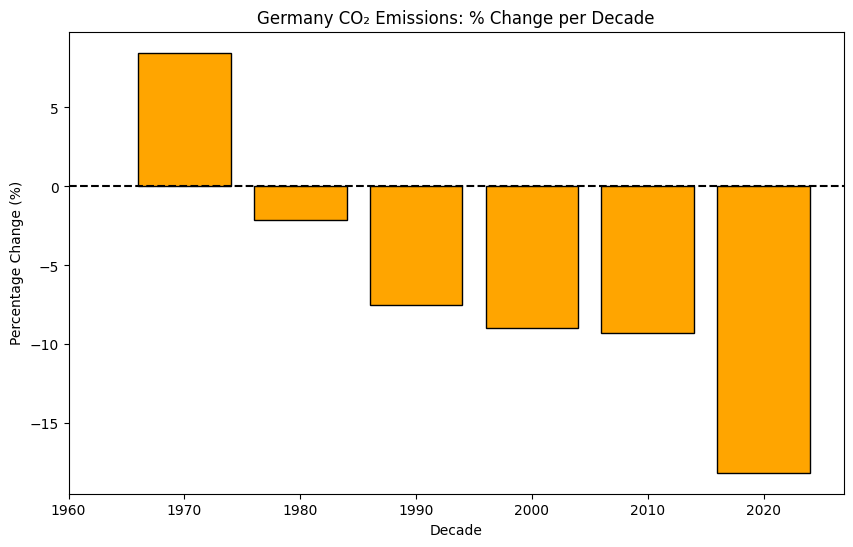

In [45]:
# --- Visualization 3: Percentage Change between Decades ---
decade_avg["pct_change"] = decade_avg["co2"].pct_change() * 100

plt.figure(figsize=(10,6))
plt.bar(decade_avg["decade"], decade_avg["pct_change"], width=8, color="orange", edgecolor="black")
plt.axhline(0, color="black", linestyle="--")
plt.title("Germany CO₂ Emissions: % Change per Decade")
plt.xlabel("Decade")
plt.ylabel("Percentage Change (%)")
plt.xticks(decade_avg["decade"])
plt.show()

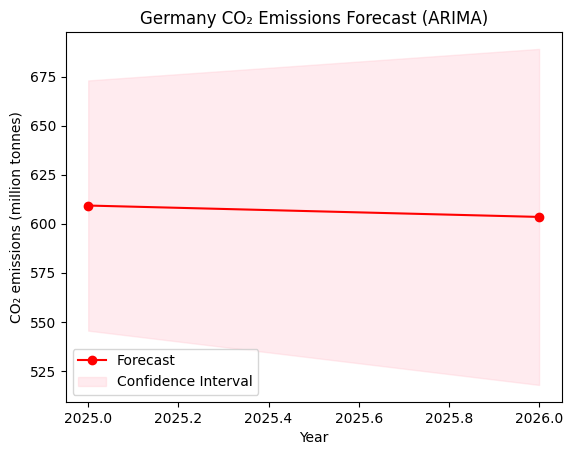

In [46]:
future_years = [2025,2026]
plt.plot(future_years, pred_mean, label="Forecast", color="red", marker="o")

# Confidence interval
plt.fill_between(future_years,
                 pred_conf["lower co2"],
                 pred_conf["upper co2"],
                 color="pink", alpha=0.3, label="Confidence Interval")

plt.title("Germany CO₂ Emissions Forecast (ARIMA)")
plt.xlabel("Year")
plt.ylabel("CO₂ emissions (million tonnes)")
plt.legend()
plt.show()

In [47]:
germany = df[["year", "co2"]].dropna().sort_values("year")
germany = germany[germany["year"] >= 2000]

# Train set: 2000–2019
train = germany[germany["year"] <= 2019].set_index("year")
test = germany[germany["year"] > 2019].set_index("year")

In [48]:
# Fit ARIMA on training data
model_arima = ARIMA(train["co2"], order=(2,1,2))
model_fit_arima = model_arima.fit()

# Forecast horizon = length of test set
forecast_arima = model_fit_arima.get_forecast(steps=len(test))
pred_mean_arima = forecast_arima.predicted_mean
pred_conf_arima = forecast_arima.conf_int()

# Align forecast years with test years
forecast_years = test.index

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

In [49]:
# Scale only training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train["co2"].values.reshape(-1,1))

# Create sequences
X_train, y_train = create_sequences(scaled_train, time_steps=10)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Train LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=8, verbose=0)

# Forecast step by step from 2020
sequence = scaled_train[-time_steps:]   # last 10 years of training
lstm_preds = []
for _ in range(len(test)):
    pred = model_lstm.predict(sequence.reshape(1, time_steps, 1), verbose=0)
    lstm_preds.append(pred[0,0])
    sequence = np.append(sequence[1:], pred).reshape(time_steps, 1)

# Convert back to original scale
lstm_preds = scaler.inverse_transform(np.array(lstm_preds).reshape(-1,1)).flatten()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


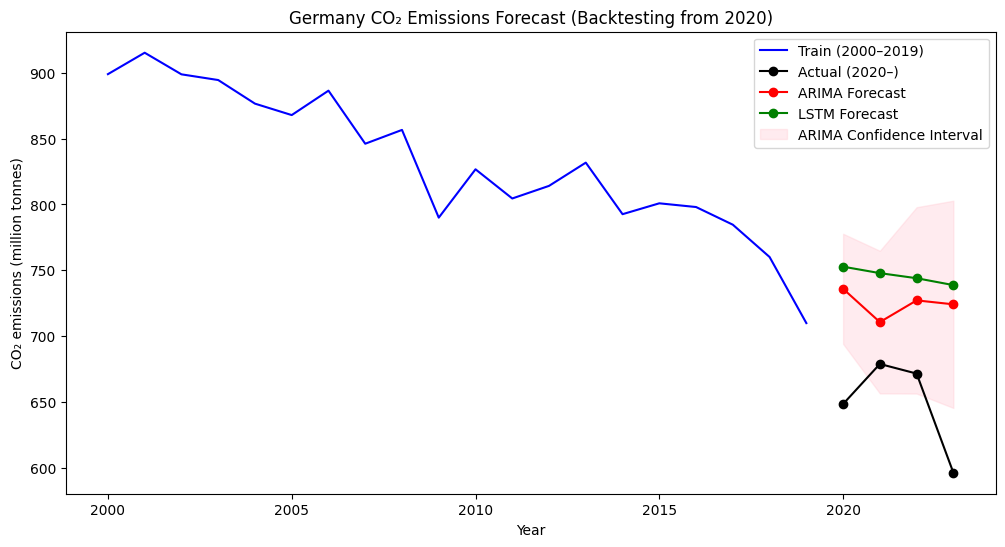

In [50]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train["co2"], label="Train (2000–2019)", color="blue")
plt.plot(test.index, test["co2"], label="Actual (2020–)", color="black", marker="o")
plt.plot(forecast_years, pred_mean_arima, label="ARIMA Forecast", color="red", marker="o")
plt.plot(forecast_years, lstm_preds, label="LSTM Forecast", color="green", marker="o")

# Add ARIMA confidence interval
plt.fill_between(forecast_years, pred_conf_arima["lower co2"], pred_conf_arima["upper co2"],
                 color="pink", alpha=0.3, label="ARIMA Confidence Interval")

plt.title("Germany CO₂ Emissions Forecast (Backtesting from 2020)")
plt.xlabel("Year")
plt.ylabel("CO₂ emissions (million tonnes)")
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

arima_preds = pred_mean_arima.values
actuals = test["co2"].values

# Errors
arima_mse = mean_squared_error(actuals, arima_preds)
lstm_mse = mean_squared_error(actuals, lstm_preds)

print("ARIMA RMSE:", np.sqrt(arima_mse))
print("LSTM RMSE:", np.sqrt(lstm_mse))
print("ARIMA MAE:", mean_absolute_error(actuals, arima_preds))
print("LSTM MAE:", mean_absolute_error(actuals, lstm_preds))

ARIMA RMSE: 83.86689968832512
LSTM RMSE: 101.51560309975918
ARIMA MAE: 75.7247837527197
LSTM MAE: 97.09225939941408


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

arima_preds = pred_mean_arima.values
actuals = test["co2"].values

# --- RMSE ---
arima_rmse = np.sqrt(mean_squared_error(actuals, arima_preds))
lstm_rmse = np.sqrt(mean_squared_error(actuals, lstm_preds))

# --- MAE ---
arima_mae = mean_absolute_error(actuals, arima_preds)
lstm_mae = mean_absolute_error(actuals, lstm_preds)

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

arima_mape = mean_absolute_percentage_error(actuals, arima_preds)
lstm_mape = mean_absolute_percentage_error(actuals, lstm_preds)

# --- Print results ---
print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"LSTM  RMSE: {lstm_rmse:.2f}")
print(f"ARIMA MAE : {arima_mae:.2f}")
print(f"LSTM  MAE : {lstm_mae:.2f}")
print(f"ARIMA MAPE: {arima_mape:.2f}%")
print(f"LSTM  MAPE: {lstm_mape:.2f}%")

ARIMA RMSE: 83.87
LSTM  RMSE: 101.52
ARIMA MAE : 75.72
LSTM  MAE : 97.09
ARIMA MAPE: 11.98%
LSTM  MAPE: 15.24%


In [58]:
# Build a DataFrame to compare Actual vs Forecasts
comparison_df = pd.DataFrame({
    "Year": test.index,
    "Actual": actuals,
    "ARIMA_Pred": arima_preds,
    "LSTM_Pred": lstm_preds
}).reset_index(drop=True)

# Compute errors for each year
comparison_df["ARIMA_Error"] = comparison_df["Actual"] - comparison_df["ARIMA_Pred"]
comparison_df["LSTM_Error"] = comparison_df["Actual"] - comparison_df["LSTM_Pred"]

print(comparison_df)

   Year   Actual  ARIMA_Pred   LSTM_Pred  ARIMA_Error  LSTM_Error
0  2020  648.357  735.877578  752.700745   -87.520578 -104.343745
1  2021  678.777  710.595128  747.794922   -31.818128  -69.017922
2  2022  671.472  727.091690  743.929321   -55.619690  -72.457321
3  2023  596.151  724.091739  738.701050  -127.940739 -142.550050


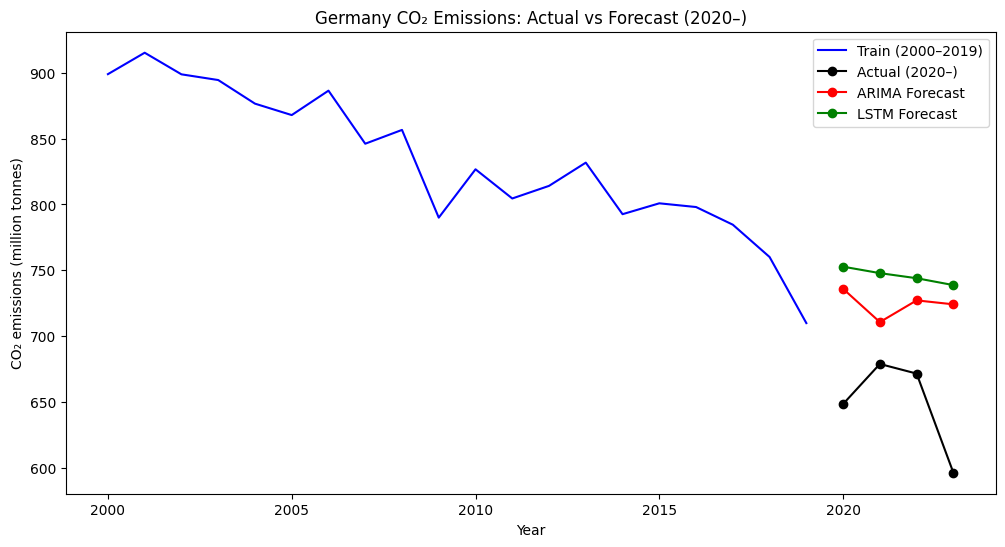

In [59]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train["co2"], label="Train (2000–2019)", color="blue")
plt.plot(test.index, test["co2"], label="Actual (2020–)", color="black", marker="o")
plt.plot(test.index, arima_preds, label="ARIMA Forecast", color="red", marker="o")
plt.plot(test.index, lstm_preds, label="LSTM Forecast", color="green", marker="o")

plt.title("Germany CO₂ Emissions: Actual vs Forecast (2020–)")
plt.xlabel("Year")
plt.ylabel("CO₂ emissions (million tonnes)")
plt.legend()
plt.show()